1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
# read data into a DataFrame
import pandas as pd
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import numpy as np
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [3]:
# Further divide default and student into their sub-catgories
df['default'] = df['default'].replace('No', 'default_0').replace('Yes', 'default_1')
df['student'] = df['student'].replace('No', 'student_0').replace('Yes', 'student_1')

2) Convert `default` and `student` to categorical variables.

In [4]:
df_default = pd.get_dummies(df['default'])
df_student = pd.get_dummies(df['student'])

df_final = pd.concat([df.drop(['default', 'student'], axis=1), df_default, 
                   df_student], axis=1)

In [5]:
df_final.head()

,balance,income,default_0,default_1,student_0,student_1
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

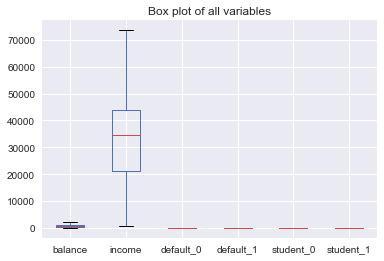

In [7]:
df_final.boxplot()
plt.title('Box plot of all variables')

Note default and students are dummy variables and they only have values "0" or "1", which make their boxplots less wide as income and balance

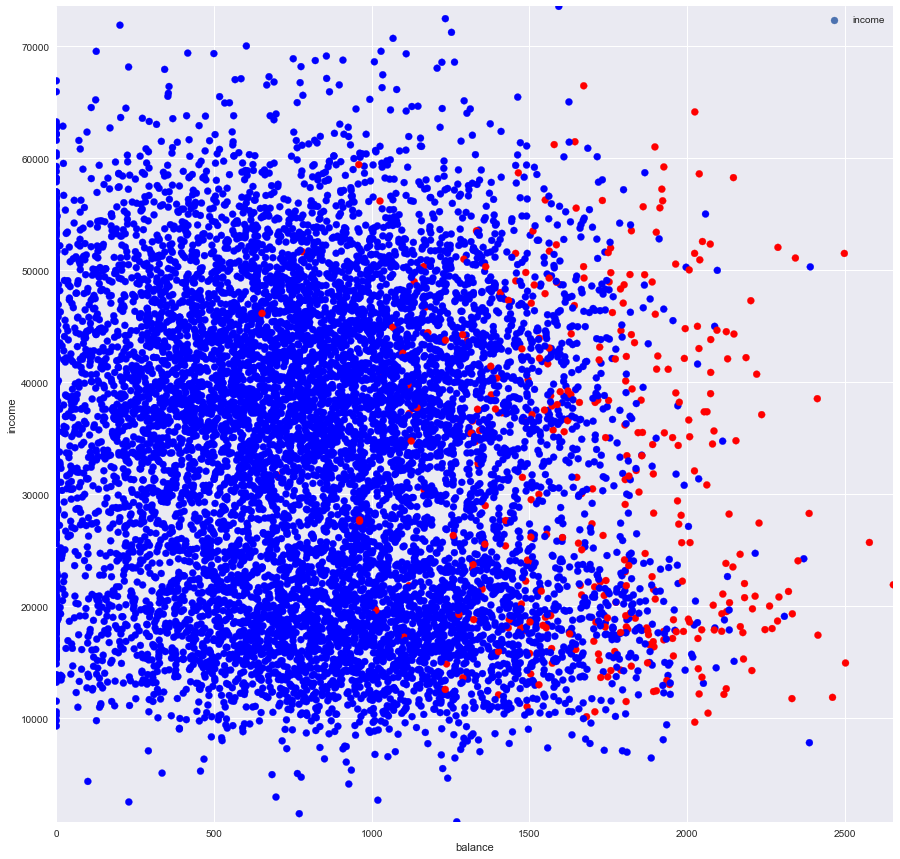

In [11]:
# Reference: https://www.datarobot.com/blog/classification-with-scikit-learn/
#scatter plot of balance (x) and income (y)

from matplotlib.colors import ListedColormap
plt.figure(figsize=(15, 15))

# scatter plot
ax1 = plt.subplot()
cm_bright = ListedColormap(['#0000FF','#FF0000'])
ax1.scatter(df.balance, df.income, c=(df.default == 'default_1'), cmap=cm_bright)        
ax1.set_xlim((df.balance.min(), df.balance.max()))
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xlabel('balance')
ax1.set_ylabel('income')
ax1.legend(loc='upper right')

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [20]:
X = df_final[['balance', 'income']].values
y = df_final.default_1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[(0, 80000), (0, 3000)]

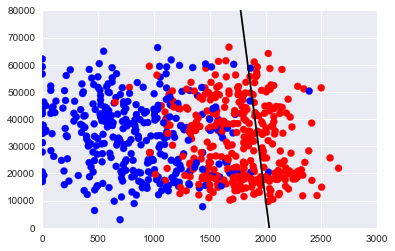

In [21]:
# Create linear regression object
regr = LogisticRegression(penalty='l1')

# Train the model using the training sets
regr.fit(X_train, y_train)

# scatter plot
ax = plt.gca()
ax.scatter(df.balance, df.income, c=(df.default == 'default_1'), cmap=cm_bright)

# plot threshold
a_1,a_2= regr.coef_[0]
dt = np.linspace(0, 3000, 3000)
# note regr.intercept is the intersection at y-axis
ax.plot(dt, (-regr.intercept_-a_1*dt)/a_2, 'k')
ax.set(xlim=(0, 3000), ylim=(0, 80000))

Area under the ROC curve : 0.960648


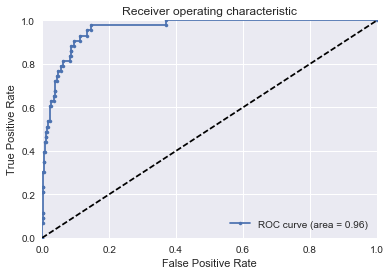

In [12]:
# X are features and y is predictive variable - cancelled HD or not.
#y = df['y'].apply(lambda y : get_y(y))
# K-fold cross validation for model selection.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
   
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred


# Scale columns for regression.
#scaler = StandardScaler()
#X = X.as_matrix().astype(np.float)
#X = scaler.fit_transform(X)

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [19]:
X = df_final[['balance', 'income', 'student_1']]
y = df_final.default_1

# Ridge
# Split the data into training/testing sets
# X_train = X[0:int(size*0.8)]
# X_test = X[int(size*0.8):]

scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)

# Split the targets into training/testing sets
# y_train = y[0:int(size*0.8)]
# y_test = y[int(size*0.8):]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = np.logspace(-3.,1.,100)-1

scores = []

for alpha in alphas:
    regr = Ridge(alpha=alpha)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test,y_test))


In [20]:
regr.coef_

array([ 0.0642667 ,  0.00306519, -0.00278252])

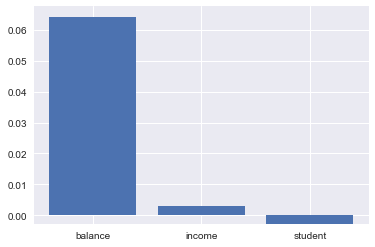

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))

In [22]:
# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')

Area under the ROC curve : 0.962152


As shown above, approximately 96.21% area is under ROC, which is slightly bigger than the previous case. Even though the performance improves, we cannot tell there is a significant improvement as "student" is added to the data, give that the improvement is too small.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [23]:
def generate_auc_1(X,y,s,clf_class,**kwargs):
    # Construct a kfolds object
    # Construct training and testing set.
    X, y = shuffle(X, y, random_state=s)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

Area under the ROC curve : 0.941410


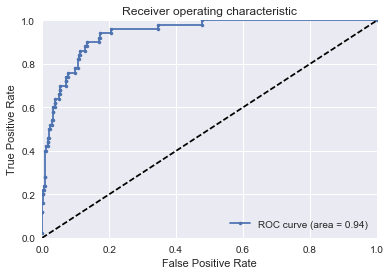

Area under the ROC curve : 0.935570


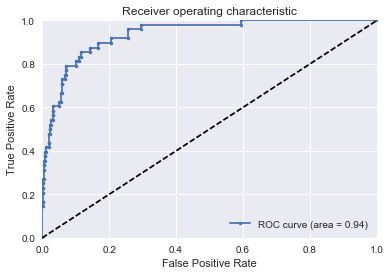

Area under the ROC curve : 0.940664


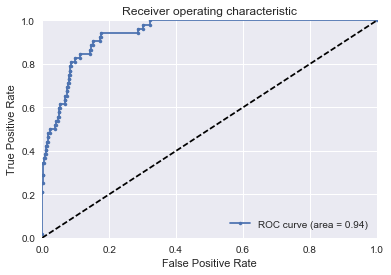

In [24]:
X = df_final[['balance', 'income']]
y = df_final.default_1
# simulate case for different random state
for s in [15, 30, 60]:
    fpr,tpr,roc_auc,thresholds = generate_auc_1(X,y,s,LogisticRegression,C=0.1,penalty='l1')
    generate_ROCplot(fpr,tpr,'LR',roc_auc)

The model is stable in that the patterns do not change significantly as we increase the random state.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [40]:
from sklearn.tree import DecisionTreeRegressor
import pydot
import pydotplus 
from IPython.display import Image

In [41]:
# create variables within dataset and split them into training and testing 
X = df_final[['balance', 'income']]
y = df_final.default_1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit regression model
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [42]:

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [43]:
from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt=DecisionTreeRegressor(max_depth=5)
dt.fit(X_train, y_train)
visualize_tree(regr_2, feature_names=['x'])

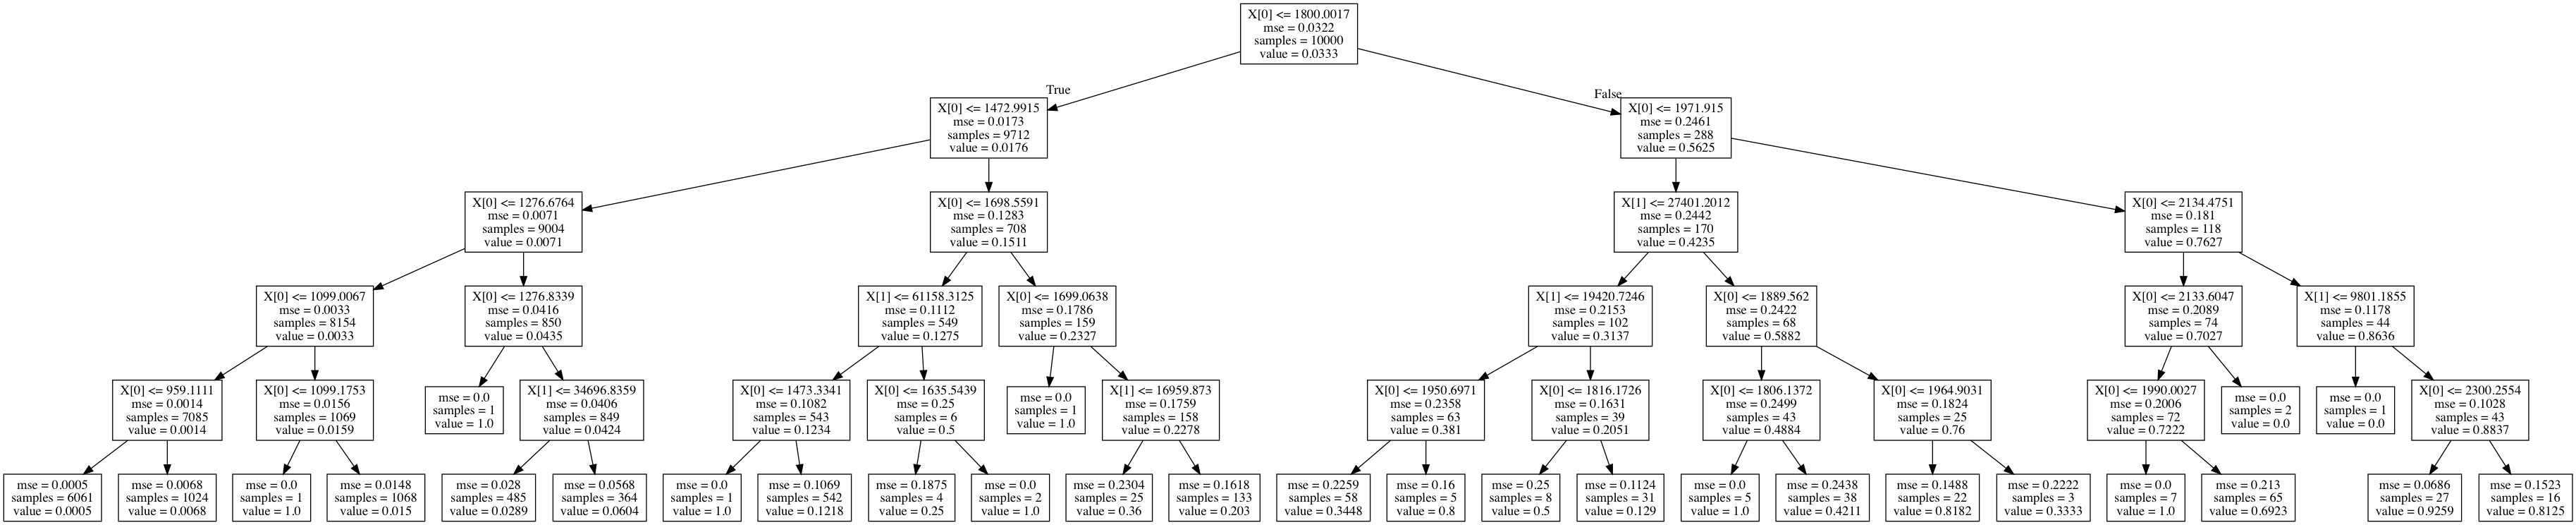

In [44]:
dot_data=export_graphviz(regr_2, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

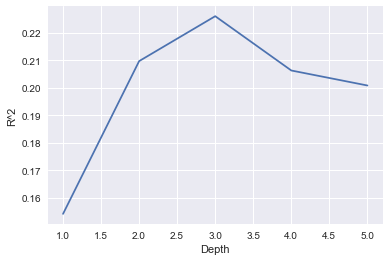

In [30]:
# Fit regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

In [31]:
print ("the optimal decision tree depth is", n_opt)

the optimal decision tree depth is 3


Area under the ROC curve : 0.951562


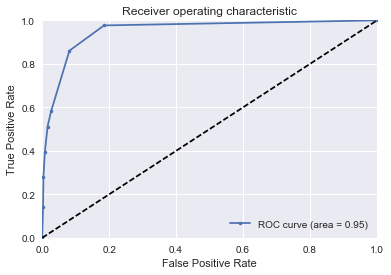

In [32]:
# plot roc

fpr,tpr,roc_auc,thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth=n_opt)

generate_ROCplot(fpr,tpr,'LR',roc_auc)